### What we have now
**Date: 12/08**

We have the following tools/descriptions:
 - Mean Structure ($t \in [\tau_s, t_f]$) of Backbones
 - End-to-End Vectors
 - Number of Molecules (Counted, 41)

We are missing:
 - Center of the fibril

With the center of the fibril one can compute:
$$
r_\text{mol} = \langle r \rangle \text{ where } r: \{r_\text{low}, r_\text{high}\}, \quad \vec{r} = \vec{r} - \vec{r}_c
$$

We could also see the representation of the helix through the plot $(\varphi, z)$

Make groupings of r so that we can see a constant $\psi$ in each group (layer).

In [1]:
import MDAnalysis as md
import matplotlib.pyplot as plt
import numpy as np

# Load data
u = md.Universe('md_1.tpr', 'md_1_noPBC.xtc')
u.trajectory[-1]
protein = u.select_atoms("protein")
backbn = protein.select_atoms("backbone")
xd, yd, zd = u.trajectory[-1].dimensions[0:3]/10

t_eq = 15000 # ps
# Time Data
ti = u.trajectory[0].time
tf = u.trajectory[-1].time
nt = len(u.trajectory)-1
deltat = (tf-ti)/nt
t = np.linspace(ti,tf,nt+1)
mask = (t >= t_eq)

Functions

In [ ]:
def get_mean_coords(molecule, mask):
    coords_saving = []
    chains = backbn.fragments[3*molecule:3*molecule + 3]
    colmol = chains[0] + chains[1] + chains[2]
    for ts in u.trajectory[mask]:
        coords = colmol.positions / 10
        coords_saving.append(coords)
    mean_coords = np.mean(coords_saving, 0)
    return mean_coords

def end_to_end_vec(coords):
    a = coords[0:-1,:]
    b = coords[1:,:]
    return np.sum(b-a, 0), a[0, :] # Final and Initial points

def e2e_triple_mean(mol, mask):
    # pick the 3 chain fragments for this molecule
    chains = backbn.fragments[3*mol:3*mol+3]

    # running means for each chain's endpoints
    start_mean = [np.zeros(3) for _ in range(3)]
    end_mean   = [np.zeros(3) for _ in range(3)]
    counts     = [0, 0, 0]

    for ts in u.trajectory[mask]:
        for j, ch in enumerate(chains):
            coords = ch.positions / 10.0
            a = coords[0]
            b = coords[-1]
            # enforce consistent direction (e.g., start has smaller z)
            if b[2] < a[2]:
                a, b = b, a
            counts[j] += 1
            start_mean[j] += (a - start_mean[j]) / counts[j]
            end_mean[j]   += (b - end_mean[j])   / counts[j]

    start_avg = np.mean(start_mean, axis=0)
    end_avg   = np.mean(end_mean,   axis=0)
    return start_avg, end_avg, start_mean

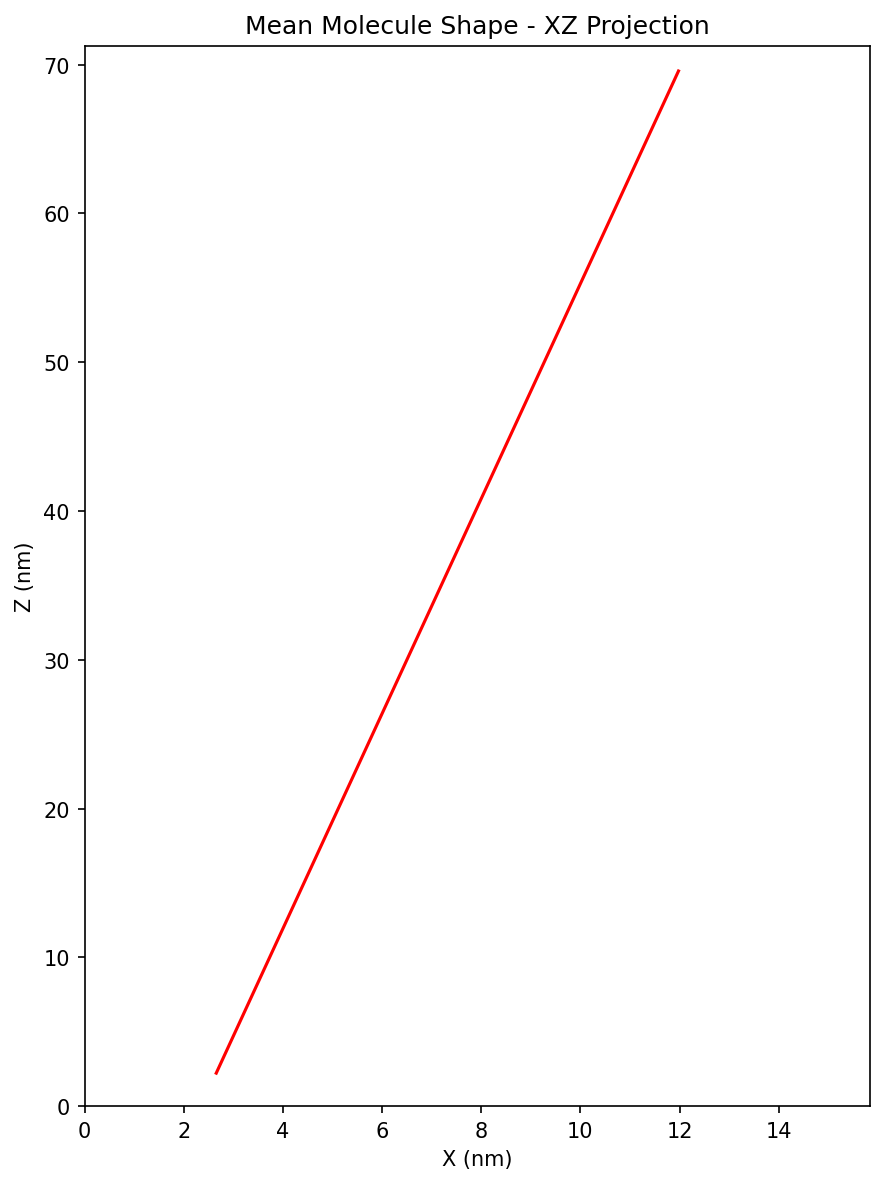

In [49]:
strt, end, stme = e2e_triple_mean(0, mask)
#mean_test = get_mean_coords(0, mask)

plt.figure(figsize=(6,8), dpi=150)

# sc = plt.scatter(mean_test[:, 0], mean_test[:,2], c=mean_test[:,1], cmap='Oranges', s=10, edgecolor='k', alpha=0.7)
# plt.colorbar(sc, label='Y coordinate (nm)')

plt.plot([strt[0], end[0]], [strt[2], end[2]], color='r')

plt.xlabel("X (nm)")
plt.ylabel("Z (nm)")
plt.title("Mean Molecule Shape - XZ Projection")
plt.xlim(0, xd)
plt.ylim(0, zd)
plt.tight_layout()
plt.show()

End-to-End Vectors of All Molecules

In [11]:
tot_mol = int((protein.fragindices[-1] + 1)/3)
etevec = []

for mol in range(tot_mol):
    mean_mol = get_mean_coords(mol, mask)
    etevec.append(end_to_end_vec(mean_mol))


Center of the Fibril

In [ ]:
fib_coords = []
# Mean
for ts in u.trajectory[mask]:
    coords = backbn.positions / 10
    fib_coords.append(coords)
fib_mean = np.mean(fib_coords, 0)

Take top and down slabs and make an end-to-end vector?

In [ ]:
nm_slab = 2
top_slab = fib_mean[fib_mean[:, 2] >= max(fib_mean[:,2]) - nm_slab]
bottom_slab =  fib_mean[fib_mean[:, 2] <= min(fib_mean[:,2]) + nm_slab]

top_vec = np.array([np.mean(top_slab[:, 0]), np.mean(top_slab[:, 1]), max(fib_mean[:,2])])
low_vec = np.array([np.mean(bottom_slab[:, 0]), np.mean(bottom_slab[:, 1]), min(fib_mean[:,2])])

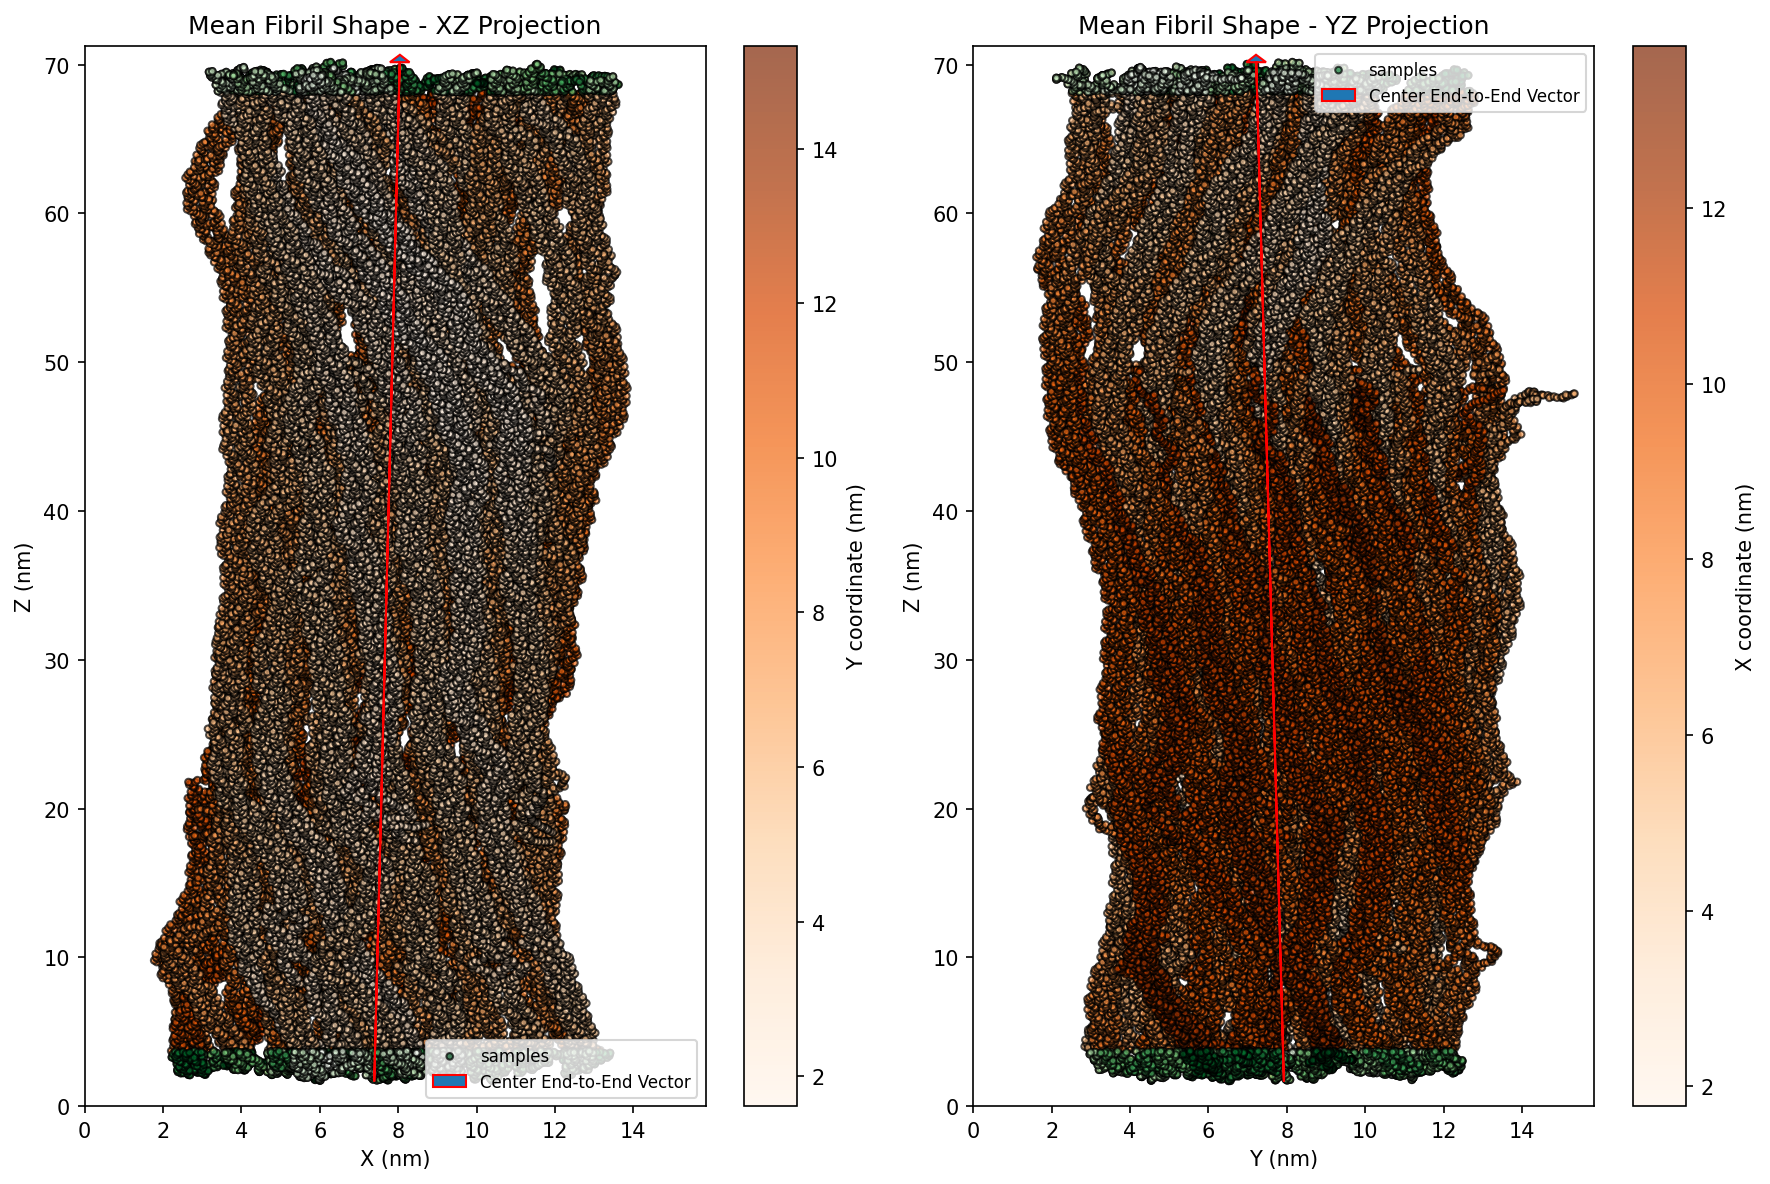

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 8), dpi=150)

# --- XZ Projection ---
sc0 = axs[0].scatter(fib_mean[:, 0], fib_mean[:, 2],
                     c=fib_mean[:, 1], cmap='Oranges',
                     s=10, edgecolor='k', alpha=0.7)
fig.colorbar(sc0, ax=axs[0], label='Y coordinate (nm)')

# Slabs - Samples
axs[0].scatter(top_slab[:, 0], top_slab[:, 2],
                     c=top_slab[:, 1], cmap='Greens',
                     s=10, edgecolor='k', alpha=0.7, label = "samples")
axs[0].scatter(bottom_slab[:, 0], bottom_slab[:, 2],
                     c=bottom_slab[:, 1], cmap='Greens',
                     s=10, edgecolor='k', alpha=0.7)

# End-to-End Center
axs[0].arrow(low_vec[0], low_vec[2], top_vec[0]-low_vec[0], top_vec[2]-low_vec[2], 
         head_width=0.5, head_length=0.5, ec='r', label = "Center End-to-End Vector")

axs[0].set_xlabel("X (nm)")
axs[0].set_ylabel("Z (nm)")
axs[0].set_title("Mean Fibril Shape - XZ Projection")
axs[0].set_xlim(0, xd)
axs[0].set_ylim(0, zd)
axs[0].legend(fontsize = 8)


# --- YZ Projection ---
sc1 = axs[1].scatter(fib_mean[:, 1], fib_mean[:, 2],
                     c=fib_mean[:, 0], cmap='Oranges',
                     s=10, edgecolor='k', alpha=0.7)
fig.colorbar(sc1, ax=axs[1], label='X coordinate (nm)')

# Slabs - Samples
axs[1].scatter(top_slab[:, 1], top_slab[:, 2],
                     c=top_slab[:, 0], cmap='Greens',
                     s=10, edgecolor='k', alpha=0.7, label = "samples")
axs[1].scatter(bottom_slab[:, 1], bottom_slab[:, 2],
                     c=bottom_slab[:, 0], cmap='Greens',
                     s=10, edgecolor='k', alpha=0.7)

# End-to-End Center
axs[1].arrow(low_vec[1], low_vec[2], top_vec[1]-low_vec[1], top_vec[2]-low_vec[2], 
         head_width=0.5, head_length=0.5, ec='r', label = "Center End-to-End Vector")

axs[1].set_xlabel("Y (nm)")
axs[1].set_ylabel("Z (nm)")
axs[1].set_title("Mean Fibril Shape - YZ Projection")
axs[1].set_xlim(0, yd)
axs[1].set_ylim(0, zd)
axs[1].legend(fontsize = 8)

plt.tight_layout()
plt.show()